In [1]:
import cv2, os, glob, random
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
#from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from model.u_net import get_unet_128, get_unet_256, get_unet_512, get_unet_1024
from keras.optimizers import RMSprop, Adam
from model.losses import bce_dice_loss, dice_loss, weighted_bce_dice_loss, weighted_dice_loss, dice_coeff
from keras.utils import multi_gpu_model
from keras.models import Model
import matplotlib.pyplot as plt
import keras
%matplotlib inline

Using TensorFlow backend.


# Configuration

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

input_size = 768

m = get_unet_1024(input_shape=(768,768,3),autoencoder = True)

max_epochs = 100
batch_size = 16
threshold = 0.5

m.summary()
plot_model( m , show_shapes=True , to_file='unet1024_encoder.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 768, 768, 3)       0         
_________________________________________________________________
enc0_conv1 (Conv2D)          (None, 768, 768, 8)       224       
_________________________________________________________________
enc0_bn1 (BatchNormalization (None, 768, 768, 8)       32        
_________________________________________________________________
enc0_relu1 (Activation)      (None, 768, 768, 8)       0         
_________________________________________________________________
enc0_conv2 (Conv2D)          (None, 768, 768, 8)       584       
_________________________________________________________________
enc0_bn2 (BatchNormalization (None, 768, 768, 8)       32        
_________________________________________________________________
enc0_relu2 (Activation)      (None, 768, 768, 8)       0         
__________

# Data input

In [3]:
AIRBUS_SHIP_TRAIN_DIR = "../Data/train"
train_data = sorted(glob.glob(AIRBUS_SHIP_TRAIN_DIR + "/*.jpg") + glob.glob(AIRBUS_SHIP_TRAIN_DIR + "/*.png"))

AIRBUS_SHIP_TEST_DIR = "../Data/test"
test_data = sorted(glob.glob(AIRBUS_SHIP_TEST_DIR + "/*.jpg") + glob.glob(AIRBUS_SHIP_TEST_DIR + "/*.png"))

TRAIN_DATA = train_data + test_data
random.shuffle(TRAIN_DATA)
print("There are {} training images found.".format(len(TRAIN_DATA)))

AIRBUS_SHIP_VAL_DIR = "../Data/val"
VAL_DATA = sorted(glob.glob(AIRBUS_SHIP_VAL_DIR + "/*.jpg") + glob.glob(AIRBUS_SHIP_VAL_DIR + "/*.png"))
print("There are {} validating images found.".format(len(VAL_DATA)))

There are 187570 training images found.
There are 5000 validating images found.


In [4]:
def randomHueSaturationValue(image, hue_shift_limit=(-180, 180),
                             sat_shift_limit=(-255, 255),
                             val_shift_limit=(-255, 255), u=0.5):
    if np.random.random() < u:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)

    return image


def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_CONSTANT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))
        if mask is not None:
            mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(
                                       0, 0,
                                       0,))

    return image, mask


def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        if mask is not None:
            mask = cv2.flip(mask, 1)

    return image, mask

class DataGenerator:
    def __init__(self, listOfImagePaths, batch_size, target_size, random_color=False, random_flip=False, random_shift_scale_rotate = False):
        self.dataGen = self._generator(listOfImagePaths, batch_size, target_size)
        self.len = int(np.ceil(float(len(listOfImagePaths)) / float(batch_size)))
        self.random_color = random_color
        self.random_flip = random_flip
        self.random_shift_scale_rotate = random_shift_scale_rotate
        
    def __len__(self):
        return self.len
    
    def __next__(self):
        return self.dataGen.next()
    
    def next(self):
        return self.__next__()
    
    def _generator(self, dataList, batch_size, input_size):
        while True:
            for start in range(0, len(dataList), batch_size):
                x_batch = []
                #y_batch = []
                end = min(start + batch_size, len(dataList))
                train_batch = dataList[start:end]
                for datum in train_batch:
                    img = cv2.imread(datum)
                    img = cv2.resize(img, (input_size, input_size))
                    #mask = cv2.imread(datum[1], cv2.IMREAD_GRAYSCALE)
                    #mask = cv2.resize(mask, (input_size, input_size))
                    
                    if self.random_color:
                        img = randomHueSaturationValue(img,
                                                   hue_shift_limit=(-50, 50),
                                                   sat_shift_limit=(-5, 5),
                                                   val_shift_limit=(-15, 15))
                        
                    if self.random_shift_scale_rotate:
                        img, _ = randomShiftScaleRotate(img, mask=None,
                                                       shift_limit=(-0.0625, 0.0625),
                                                       scale_limit=(-0.1, 0.1),
                                                       rotate_limit=(-0, 0))
                    if self.random_flip:
                        img, _ = randomHorizontalFlip(img, mask = None)
                        
                    #mask[mask>0] = 1
                    #mask = np.expand_dims(mask, axis=2)
                    x_batch.append(img)
                    #y_batch.append(mask)
                x_batch = np.array(x_batch, np.float32)
                #y_batch = np.array(y_batch, np.float32)
                yield x_batch/255., x_batch

In [5]:
train_g = DataGenerator(TRAIN_DATA,batch_size=1, \
                        target_size=input_size, \
                        random_color = True, \
                        random_flip = True, \
                        random_shift_scale_rotate = True)
val_g = DataGenerator(VAL_DATA, \
                      batch_size = 2, \
                      target_size = input_size, \
                      random_color = False, \
                      random_flip = False, \
                      random_shift_scale_rotate = False)
print(len(train_g),len(val_g))

(187570, 2500)


(2, 768, 768, 3)
(2, 768, 768, 3)
(2, 768, 768, 3)
(2, 768, 768, 3)
(2, 768, 768, 3)
(2, 768, 768, 3)
(2, 768, 768, 3)
(2, 768, 768, 3)
(2, 768, 768, 3)
(2, 768, 768, 3)


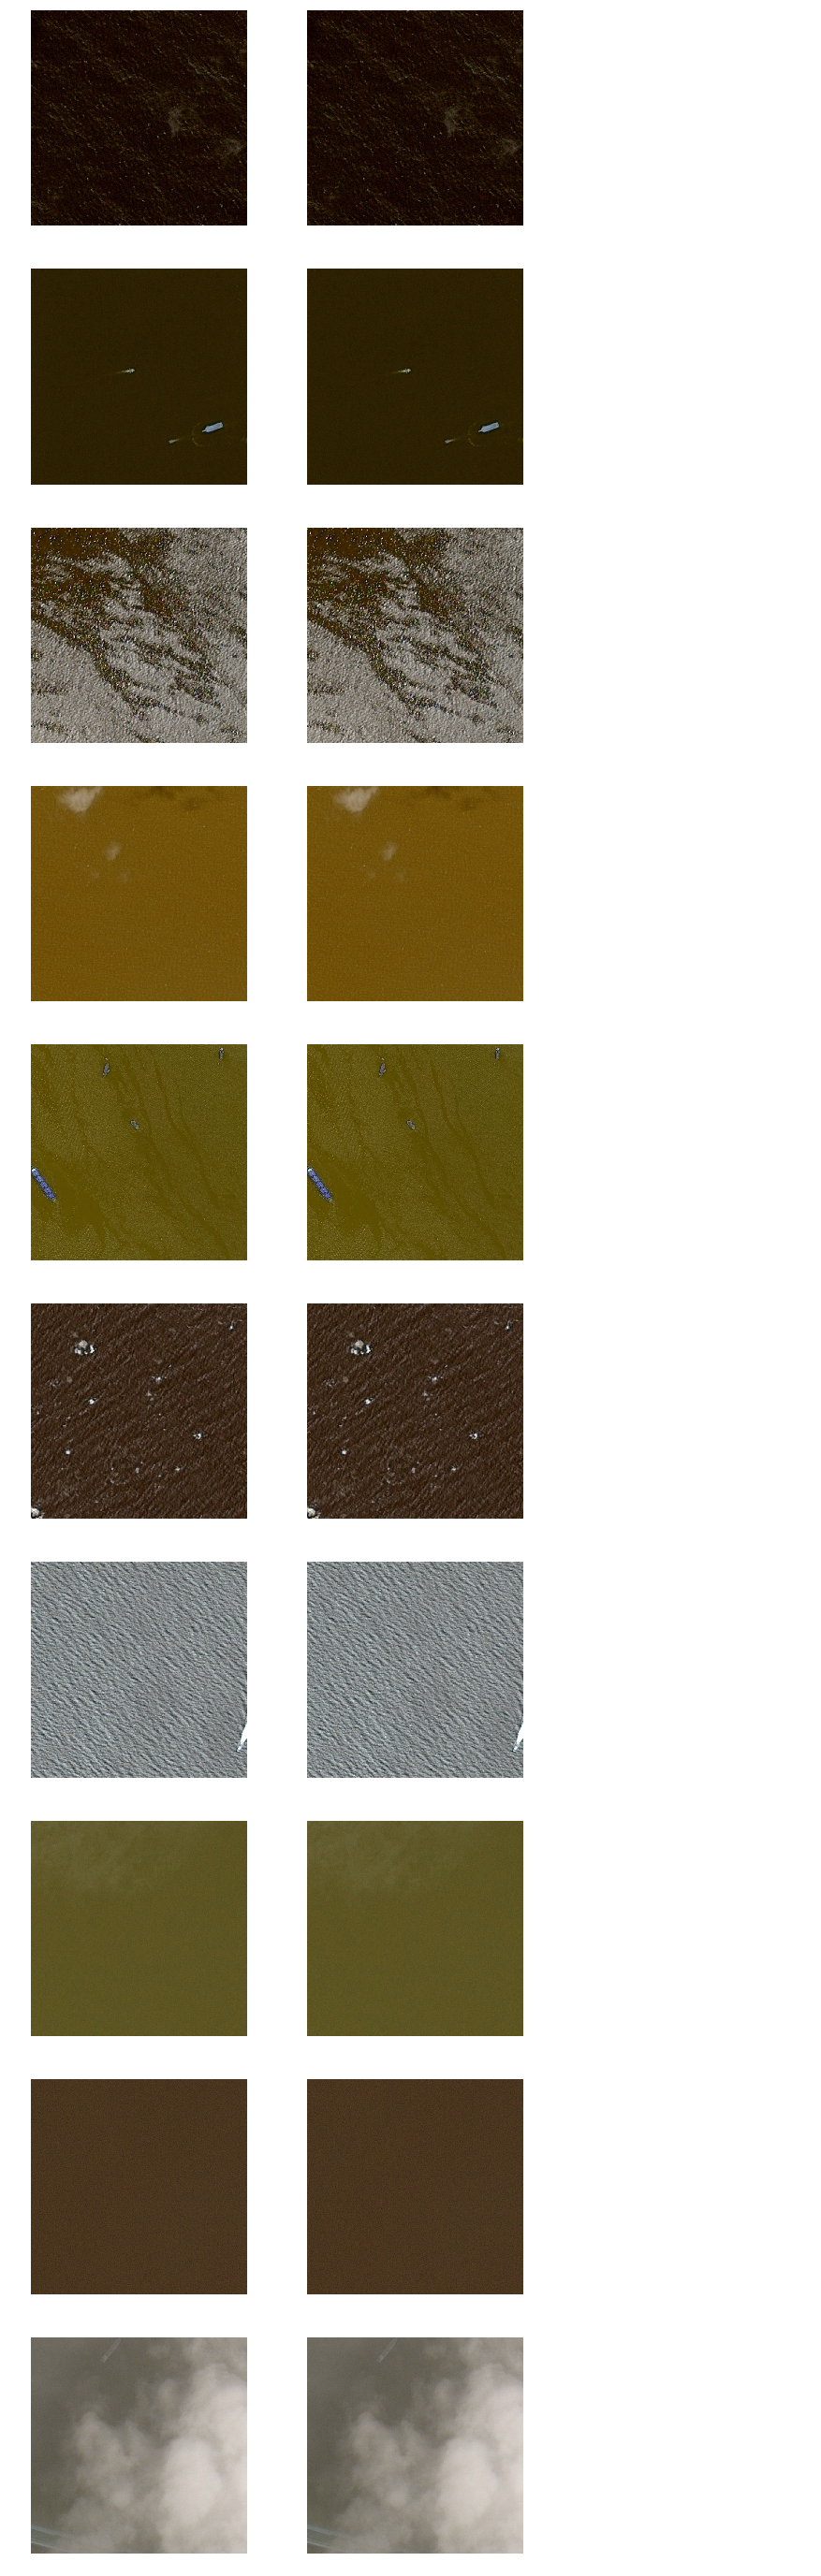

In [6]:
NUM_SAMPLES = 10
fig, m_axs = plt.subplots(NUM_SAMPLES, 3, figsize = (15, 50))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3), idx in zip(m_axs, range(NUM_SAMPLES)):
    img, mask = val_g.next()
    ax1.imshow((img[0]))
    print(mask.shape)
    ax2.imshow(mask[0].astype(np.uint8))

# Train

In [7]:
 callbacks = [
#     EarlyStopping(monitor='val_loss',
#                            patience=8,
#                            verbose=1,
#                            min_delta=1e-4),
#              ReduceLROnPlateau(monitor='val_loss',
#                                factor=0.1,
#                                patience=4,
#                                verbose=1,
#                                epsilon=1e-4),
#              ModelCheckpoint(monitor='val_loss',
#                              filepath='weights/best_weights.hdf5',
#                              save_best_only=True,
#                              save_weights_only=True),
#              TensorBoard(log_dir='logs')
 ]


m.fit_generator(generator=train_generator(),
                    steps_per_epoch=np.ceil(float(len(ids_train_split)) / float(batch_size)),
                    epochs=epochs,
                    verbose=2,
                    callbacks=callbacks,
                    validation_data=valid_generator(),
                    validation_steps=np.ceil(float(len(ids_valid_split)) / float(batch_size)

In [8]:
PRETRAINED_WEIGHTS = "./weights/0_unet_768_autoencoder_ep01_TrainLoss~553.1892_ValLoss~554.1521.h5"
m.load_weights(PRETRAINED_WEIGHTS)

In [9]:
num_gpus = len(os.environ["CUDA_VISIBLE_DEVICES"].split(","))
#paralell_m = multi_gpu_model(m, gpus=2)
if num_gpus >= 2:
    paralell_m = multi_gpu_model(m, gpus=num_gpus)
    paralell_m.summary()
else:
    paralell_m = m
    
optimizer = Adam(lr=1e-3)
#optimizer = RMSprop(lr=0.0001)
paralell_m.compile(optimizer=optimizer, loss='mse', metrics=['mse'])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 768, 768, 3)  0           input_img[0][0]                  
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 768, 768, 3)  0           input_img[0][0]                  
__________________________________________________________________________________________________
model_1 (Model)                 (None, 768, 768, 3)  28341203    lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
__________

In [10]:
model_name = "0_unet_768_autoencoder"
save_weights_path = "weights/"

epochs = 10
if num_gpus >= 2:
    train_batch_size = 10
    val_batch_size = 10
else:
    train_batch_size = 5
    val_batch_size = 5



G_train = DataGenerator(TRAIN_DATA, \
                        batch_size=train_batch_size, \
                        target_size=input_size, \
                        random_color = True, \
                        random_flip = True, \
                        random_shift_scale_rotate = False)
train_steps = len(G_train)

G_val = DataGenerator(VAL_DATA, \
                      batch_size = val_batch_size, \
                      target_size = input_size, \
                      random_color = False, \
                      random_flip = False, \
                      random_shift_scale_rotate = False)
val_steps = len(G_val)

In [11]:
#train_steps = 100
for ep in range(3,epochs):
    history = paralell_m.fit_generator( G_train, train_steps, \
                                        validation_data=G_val , \
                                        validation_steps=val_steps, \
                                        epochs=1, \
                                        callbacks=callbacks, verbose=1, \
                                        max_queue_size=20, workers=8, \
                                        use_multiprocessing=False )
    weight_path = save_weights_path + model_name + \
                "_ep{:02d}_TrainLoss~{:.4f}_ValLoss~{:.4f}.h5".format(ep, \
                history.history['mean_squared_error'][0],history.history['val_mean_squared_error'][0])
    m.save_weights(weight_path)
    print(">>>")
    print(">>>>EPOCH {}: Saving model to {} <<<<".format(ep,weight_path))
    print(">>>")

Epoch 1/1
18757/18757 [==============================] - 14666s 782ms/step - loss: 632.4792 - mean_squared_error: 515.9198 - val_loss: 453.9440 - val_mean_squared_error: 390.8797
>>>
>>>>EPOCH 3: Saving model to weights/0_unet_768_autoencoder_ep03_TrainLoss~515.9198_ValLoss~390.8797.h5 <<<<
>>>
Epoch 1/1
18757/18757 [==============================] - 14672s 782ms/step - loss: 538.7488 - mean_squared_error: 488.5807 - val_loss: 613.1885 - val_mean_squared_error: 571.5296
>>>
>>>>EPOCH 4: Saving model to weights/0_unet_768_autoencoder_ep04_TrainLoss~488.5807_ValLoss~571.5296.h5 <<<<
>>>
Epoch 1/1
18757/18757 [==============================] - 14663s 782ms/step - loss: 501.0471 - mean_squared_error: 463.9239 - val_loss: 435.1490 - val_mean_squared_error: 401.0448
>>>
>>>>EPOCH 5: Saving model to weights/0_unet_768_autoencoder_ep05_TrainLoss~463.9239_ValLoss~401.0448.h5 <<<<
>>>
Epoch 1/1
18757/18757 [==============================] - 14667s 782ms/step - loss: 462.4951 - mean_squared_error

In [ ]:
#train_steps = 100
for ep in range(3,epochs):
    history = paralell_m.fit_generator( G_train, train_steps, \
                                        validation_data=G_val , \
                                        validation_steps=val_steps, \
                                        epochs=1, \
                                        callbacks=callbacks, verbose=1, \
                                        max_queue_size=20, workers=8, \
                                        use_multiprocessing=False )
    weight_path = save_weights_path + model_name + \
                "_ep{:02d}_TrainLoss~{:.4f}_ValLoss~{:.4f}.h5".format(ep, \
                history.history['mean_squared_error'][0],history.history['val_mean_squared_error'][0])
    m.save_weights(weight_path)
    print(">>>")
    print(">>>>EPOCH {}: Saving model to {} <<<<".format(ep,weight_path))
    print(">>>")

Epoch 1/1
  355/18757 [..............................] - ETA: 4:16:11 - loss: 523.0826 - mean_squared_error: 523.0826

In [ ]:
#train_steps = 100
for ep in range(0,epochs):
    history = paralell_m.fit_generator( G_train, train_steps, \
                                        validation_data=G_val , \
                                        validation_steps=val_steps, \
                                        epochs=1, \
                                        callbacks=callbacks, verbose=1, \
                                        max_queue_size=20, workers=8, \
                                        use_multiprocessing=False )
    weight_path = save_weights_path + model_name + \
                "_ep{:02d}_TrainLoss~{:.4f}_ValLoss~{:.4f}.h5".format(ep, \
                history.history['mean_squared_error'][0],history.history['val_mean_squared_error'][0])
    m.save_weights(weight_path)
    print(">>>")
    print(">>>>EPOCH {}: Saving model to {} <<<<".format(ep,weight_path))
    print(">>>")

Epoch 1/1
  260/18757 [..............................] - ETA: 6:27:46 - loss: 3072.5038 - mean_squared_error: 3072.5037

In [ ]:
model_name = "0_unet_1024_autoencoder"
save_weights_path = "weights/"

epochs = 10
if num_gpus >= 2:
    train_batch_size = 10
    val_batch_size = 10
else:
    train_batch_size = 5
    val_batch_size = 5



G_train = DataGenerator(TRAIN_DATA[:80], \
                        batch_size=train_batch_size, \
                        target_size=input_size, \
                        random_color = False, \
                        random_flip = False, \
                        random_shift_scale_rotate = False)
train_steps = len(G_train)

G_val = DataGenerator(VAL_DATA[:40], \
                      batch_size = val_batch_size, \
                      target_size = input_size, \
                      random_color = False, \
                      random_flip = False, \
                      random_shift_scale_rotate = False)
val_steps = len(G_val)

train_steps = 100
for ep in range(0,epochs):
    history = paralell_m.fit_generator( G_train, train_steps, \
                                        validation_data=G_val , \
                                        validation_steps=val_steps, \
                                        epochs=1, \
                                        callbacks=callbacks, verbose=1, \
                                        max_queue_size=20, workers=8, \
                                        use_multiprocessing=False )
    weight_path = save_weights_path + model_name + \
                "_ep{:02d}_TrainLoss~{:.4f}_ValLoss~{:.4f}.h5".format(ep, \
                history.history['mean_squared_error'][0],history.history['val_mean_squared_error'][0])
    m.save_weights(weight_path)
    print(">>>")
    print(">>>>EPOCH {}: Saving model to {} <<<<".format(ep,weight_path))
    print(">>>")

Epoch 1/1
100/100 [==============================] - 130s 1s/step - loss: 2300.1808 - mean_squared_error: 2300.1808 - val_loss: 2210.4471 - val_mean_squared_error: 2210.4471
>>>
>>>>EPOCH 0: Saving model to weights/0_unet_1024_autoencoder_ep00_TrainLoss~2300.1808_ValLoss~2210.4471.h5 <<<<
>>>
Epoch 1/1
100/100 [==============================] - 124s 1s/step - loss: 1394.8745 - mean_squared_error: 1394.8745 - val_loss: 1943.9865 - val_mean_squared_error: 1943.9865
>>>
>>>>EPOCH 1: Saving model to weights/0_unet_1024_autoencoder_ep01_TrainLoss~1394.8745_ValLoss~1943.9865.h5 <<<<
>>>
Epoch 1/1
100/100 [==============================] - 124s 1s/step - loss: 1193.5272 - mean_squared_error: 1193.5272 - val_loss: 1878.3239 - val_mean_squared_error: 1878.3239
>>>
>>>>EPOCH 2: Saving model to weights/0_unet_1024_autoencoder_ep02_TrainLoss~1193.5272_ValLoss~1878.3239.h5 <<<<
>>>
Epoch 1/1
100/100 [==============================] - 123s 1s/step - loss: 1074.7361 - mean_squared_error: 1074.7361 - 

In [11]:
history.history

{'loss': [3547.9549169921875],
 'mean_squared_error': [3547.954892578125],
 'val_loss': [7568.48681640625],
 'val_mean_squared_error': [7568.4890625]}

In [ ]:
history.history

In [13]:
G_train = DataGenerator(TRAIN_DATA, \
                        batch_size=1, \
                        target_size=input_size, \
                        random_color = False, \
                        random_flip = False, \
                        random_shift_scale_rotate = False)

(1, 1024, 1024, 1)
(1, 1024, 1024, 1)
(1, 1024, 1024, 1)
(1, 1024, 1024, 1)
(1, 1024, 1024, 1)
(1, 1024, 1024, 1)
(1, 1024, 1024, 1)
(1, 1024, 1024, 1)
(1, 1024, 1024, 1)
(1, 1024, 1024, 1)


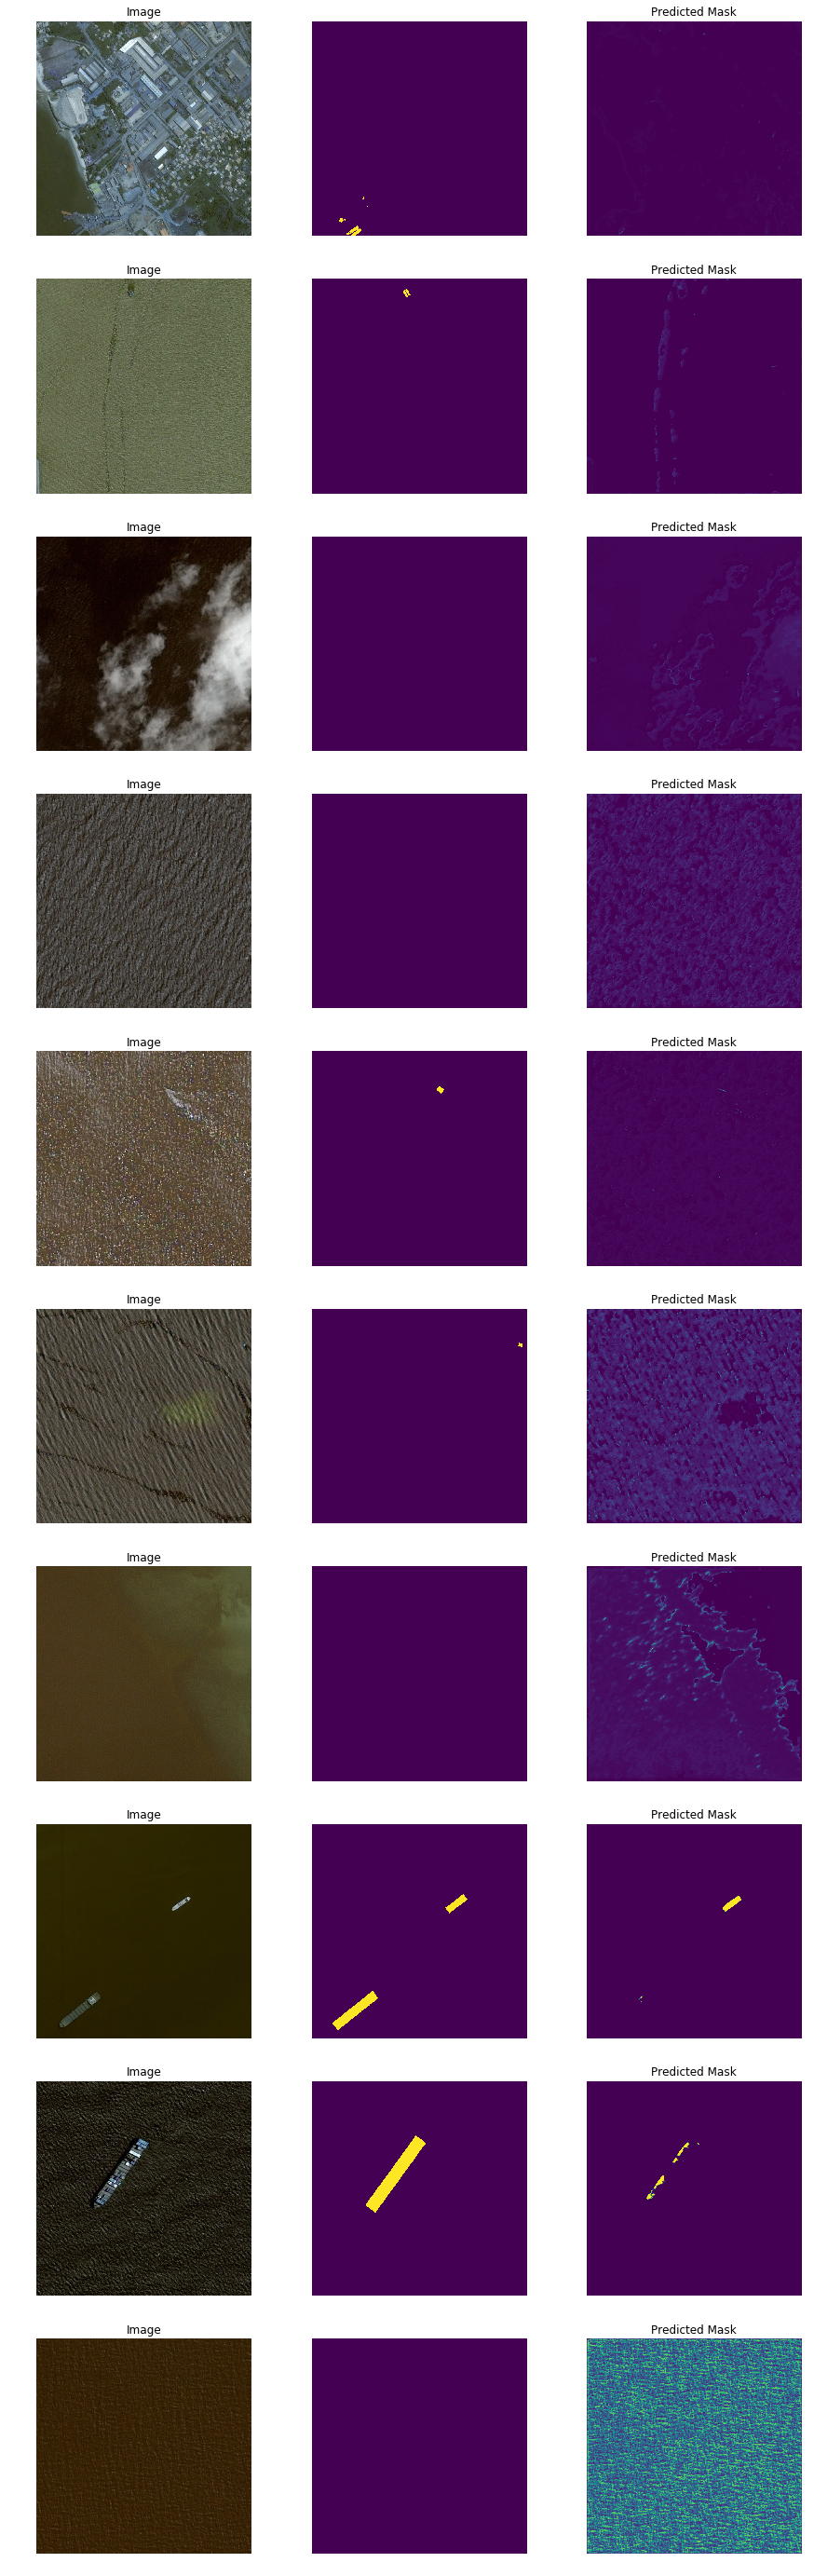

In [16]:
NUM_SAMPLES = 10
fig, m_axs = plt.subplots(NUM_SAMPLES, 3, figsize = (15, 50))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3), idx in zip(m_axs, range(NUM_SAMPLES)):
    img, (mask,_) = G_train.next()
    ax1.imshow((img[0]))
    ax1.set_title('Image')
    print(mask.shape)
    ax2.imshow(mask[0].squeeze())
    mask,_ = m.predict(img)
    #mask[mask<0.5]=0
    #mask[mask>=0.5]=1
    ax3.imshow(mask[0].squeeze())
    ax3.set_title('Predicted Mask')